# Worksheet 3: Thresholds and extremes analysis
The following exercises demonstrate analysis of moderate extremes in climate simulated using
PRECIS. As with the other worksheets, these are just examples of some of the analysis that you
might perform using packages such as Python and and the python Library IRIS.

<div class="alert alert-block alert-warning">
<b>By the end of this worksheet you should be able to:</b><br> 
- <br>
- <br>
- 
</div>

In [1]:
# Code preamble - these libraries will be used in this worksheet.
# This code block needs to be re-run every time you restart this worksheet!
%matplotlib inline 
import os
import iris
import iris.coord_categorisation
import iris.quickplot as qplt
import iris.plot as iplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import dask
dask.config.set(get=dask.get)
import dask.array as da
from iris.analysis import Aggregator

# /data/users/ssadri/pyprecis/monthly
# Some helpful data locations
DATADIR = '/project/precis/worksheets/data'
APHRODIR = os.path.join(DATADIR, 'APHRODITE')
CRUDIR = os.path.join(DATADIR, 'CRU')
CLIMDIR = os.path.join(DATADIR, 'climatology')
MODELDIR = os.path.join(DATADIR, 'netcdf')
JOBIDS = ['cahpa', 'cahpb']
TIME_PERIODS = {'baseline':'1981_1983', 'future':'2021_2050'}


## 3.1 Frequency of wet days

Start by finding the frequency of wet days using daily data For both ___cahpa___ and ___cahpb___.  Calculate the number of days in both the baseline and future periods which are wet days - a wet day is defined as having precipitation >=1 mm/day.  Then calculate the percentage of wet days.


In [15]:
# For each day: Is rainfall >= 1? True/False
# Sum over all days to get number of wet days at each grid point
# Do for both model runs and time periods
# Then calcuate the percentage of wet days

# Define a new aggregator to help count non-zero days
count_nonzero = Aggregator('count', None,
                           units_func=lambda units: 1,
                           lazy_func=da.count_nonzero)

for runid in JOBIDS:
    for period in TIME_PERIODS.keys():
        # Get path to daily data
        infile = os.path.join(MODELDIR, runid, f'{runid}.pa.{TIME_PERIODS[period]}.pr.*.nc')
        data = iris.load_cube(infile)
        # Use of a custom aggregator that uses dask array to reduce memory load
        model_wetdays = data.collapsed('time', count_nonzero)
        # Save collapsed cube to netcdf
        outfile = os.path.join(CLIMDIR, f'{runid}.pa.{TIME_PERIODS[period]}.wetday.nc')
        iris.save(model_wetdays, outfile)        
        # Find wet days as a percentage of total days
        total_days = data.coord('time').shape[0]  # Note that this is a 360 day calendar!
        model_pcent_wetdays = iris.analysis.maths.divide(iris.analysis.maths.multiply(model_wetdays, 100), total_days)
        # Save output
        outfile = os.path.join(CLIMDIR, f'{runid}.pa.{TIME_PERIODS[period]}.wetday.pcent.nc')
        iris.save(model_pcent_wetdays, outfile)


__b)__ Calculate numbers of wet days and percentage of wet days from the ___APHRODITE___ observations. This is an observational dataset for 1951-2015. There are 10957 days in the ___APHRODITE___ data which uses a real (365.25 day) calendar.


In [14]:
infile = os.path.join(APHRODIR, 'aphro.day.1981_1983.nc')
obs = iris.load_cube(infile, 'daily precipitation analysis interpolated onto 0.25deg grids [mm/day]')
# Find number of days in dataset
number_aphro_days = len(obs.coord('time').points)
# Find number of wet days
obs_wetdays = obs.collapsed('time', count_nonzero)
# Save ouput
outfile = os.path.join(CLIMDIR, 'aphro.wetday.nc')
iris.save(obs_wetdays, outfile)
# Find wet days percent
obs_pcent_wetdays = iris.analysis.maths.divide(iris.analysis.maths.multiply(obs_wetdays, 100), number_aphro_days)
outfile = os.path.join(CLIMDIR, 'aphro.wetday.pcent.nc')
iris.save(obs_pcent_wetdays, outfile)

/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1737: UserWarning: Skipping global attribute 'calendar': 'calendar' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1737: UserWarning: Skipping global attribute 'calendar': 'calendar' is not a permitted attribute
  warnings.warn(msg.format(attr_name, str(e)))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))


## Plotting

/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1725: UnknownCellMethodWarning: NetCDF variable 'precipitation_flux' contains unknown cell method 'count'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'grid_longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'grid_latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/opt/scitools/environments/experimental/2018_10_16-1/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1725: UnknownCellMethodWarning: NetCDF variable 'precipitation_flux' contains unknown c

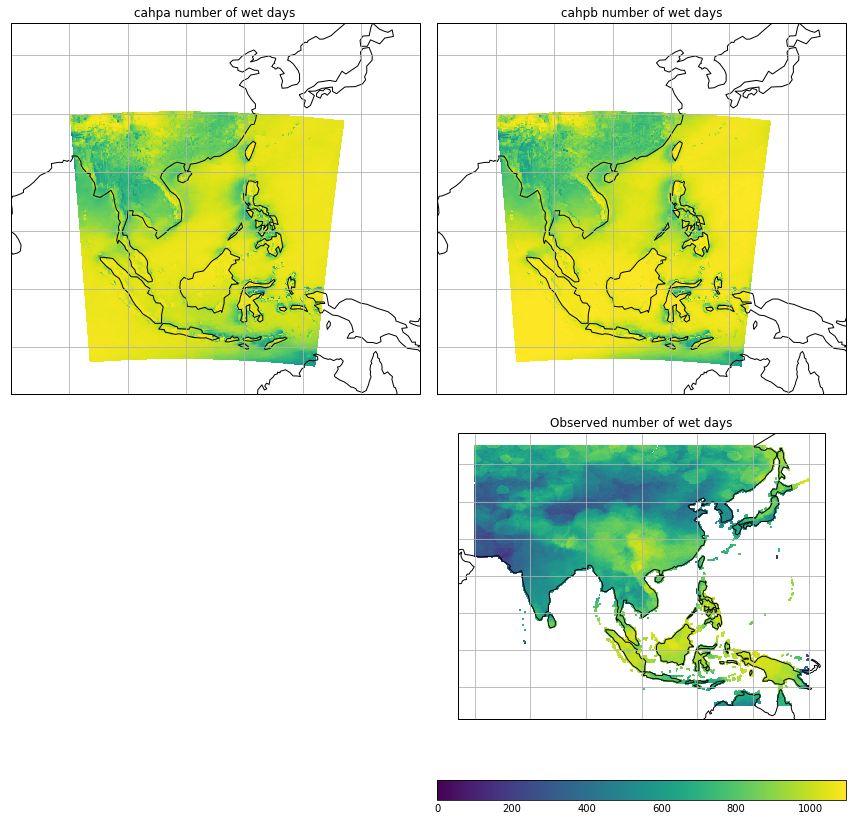

In [23]:
# Plot modelled and observed numbers of wet days and percentages of wet days
# Create a figure of the size 12x12 inches for plots
fig = plt.figure(figsize=(12, 12))

# Read in the percentage differences in precipitation between the models and obs, and plot them.
for n, runid in enumerate(JOBIDS):
    # Load baseline data
    infile = os.path.join(CLIMDIR, f'{runid}.pa.1981_1983.wetday.nc')
    nwetdays = iris.load_cube(infile)
    plotnum = 1 + n*2
    ax1 = fig.add_subplot(2, 2, n+1, projection=ccrs.PlateCarree())
    iplt.pcolormesh(nwetdays, vmin=0, vmax=number_aphro_days)
    plt.title(runid + ' number of wet days')
    ax1.coastlines()             # adds coastlines defined by the axes of the plot
    ax1.gridlines()              # adds x and y grid lines to the plot
    ax1.grid(True)
    ax1.set_extent([80,150,-15,40])

# Plot APHRODITE data
infile = os.path.join(CLIMDIR, 'aphro.wetday.nc')
obs_nwetdays = iris.load_cube(infile)
fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
qplt.pcolormesh(obs_nwetdays, vmin=0, vmax=number_aphro_days)
plt.title('Observed number of wet days')
ax = plt.gca()              # gca function that returns the current axes
ax.coastlines()             # adds coastlines defined by the axes of the plot
ax.gridlines()              # adds x and y grid lines to the plot

plt.tight_layout()          # automatically adjusts subplot(s) to fit in to the figure area
plt.show()

__c)__ Calculate the difference in modelled future and baseline wet day frequency and also modelled baseline and
observation wet day frequency.

In [ ]:
# Load percentage of wet days data for the APHRODITE observations
obs = iris.load_cube(PATH_CLIM + 'aphro.wetday.pcent.nc')

# The observed rainfall data have been created using surface rain gauges, and so are only available
# over land points.  Define a mask to remove sea points. The mask is True for masked points.
mask = np.where(obs.data > 0.0, False, True)

# Redefine the data array of the obs as a masked array.
obs.data = np.ma.array(obs.data, mask=mask)

# Define regridding method
scheme = iris.analysis.Linear(extrapolation_mode='mask')

for runid in ['cahpa', 'cahpb']:
    model_baseline = iris.load_cube(PATH_CLIM + runid + 'a.wetday.pcent.baseline.nc')
    model_future = iris.load_cube(PATH_CLIM + runid + 'a.wetday.pcent.future.nc')

    print model_baseline
    iris.util.promote_aux_coord_to_dim_coord(model_baseline, 'latitude')
# In order to compare the modelled and observed numbers of wet days,
# need to regrid the percentage differences from the model to the APHRODITE grid
    model_baseline_rg = model_baseline.regrid(obs, scheme)
    model_future_rg = model_future.regrid(obs, scheme)

    diff_model = iris.analysis.maths.subtract(model_future_rg, model_baseline_rg)
    iris.save(diff_model, PATH_CLIM + runid + 'a.wetday.pcent.diff.nc')

# Subtract the observed percentages of wet days from the modelled percentages
    diff_mod_obs = obs.copy()
    diff_mod_obs.data = model_baseline_rg.data - obs.data
    iris.save(diff_mod_obs, PATH_CLIM + runid + 'a.wetday.pcent.obs_diff.nc')
    

__2. a) Plot the difference in the percentage of wet day frequency between the models and observations.  The model domain is smaller than the observations domain, so we select the model domain when plotting using the cub.intersection method.__


In [ ]:
%matplotlib inline

import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt

iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True

path_clim = "daily/climatology/"
jobids = ['cahpa', 'cahpb']

# Create a figure of the size 12x12 inches
plt.figure(figsize=(12, 12))

# Read in the percentage differences in precipitation between the models and obs, and plot them.

for n, jobid in enumerate(jobids):
    pcent_diff = iris.load_cube(path_clim + jobid + 'a.wetday.pcent.obs_diff.nc')
    plt.subplot(2, 2, n+1)
    qplt.pcolormesh(pcent_diff.intersection(longitude=(90, 137), latitude=(-20, 32)), vmax=30, vmin=-30)
    plt.title(jobid + ' precip difference (model-obs, %)')
    ax = plt.gca()
    ax.coastlines()
    ax.gridlines()

for n, jobid in enumerate(jobids):
    pcent_diff = iris.load_cube(path_clim + jobid + 'a.wetday.pcent.diff.nc')
    plt.subplot(2, 2, n+3)
    qplt.pcolormesh(pcent_diff.intersection(longitude=(90, 137), latitude=(-20, 32)), vmax=10, vmin=-10)
    plt.title(jobid + ' precip change (fut-base, %)')
    ax = plt.gca()
    ax.coastlines()
    ax.gridlines()

plt.tight_layout()
plt.show()


## 3.2. Calculating percentiles

__1 a. ) Calculate in mm/day the baseline (1961-1990) and future (2021-2050) 95th percentile of
precipitation. Do this for cahpa, cahpb and also for APHRODITE baseline.__


In [ ]:
import iris
import numpy as np

iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True

path_clim = 'daily/climatology/'

time_periods = ['6190', '2150']
time_period_names = ['baseline', 'future']

for runid in ['cahpa', 'cahpb']:
    data_path = 'daily/' + runid + '/05216/'
    for tp, tpn in zip(*(time_periods, time_period_names)):
        filename = runid + 'a.pa.' + tp + '.05216.rr8.mmday.nc'
        model_precip = iris.load_cube(data_path + filename)
        model_pc95 = model_precip.collapsed('time', iris.analysis.PERCENTILE, percent=95.0)
        model_file_out = runid + 'a.pc95.05216.' + tpn + '.mmday.nc'
        iris.save(model_pc95, path_clim + model_file_out)


In [ ]:
# Repeat for the APHRODITE data

import iris
import numpy as np

iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True

path_clim = 'daily/climatology/'

# Define a mask to remove the sea points, as there are no observations over the sea.
obs_wetday_no = iris.load_cube(path_clim + 'aphro.wetday.no.nc')
mask = np.where(obs_wetday_no.data > 0.0, False, True)

obs_path = 'daily/APHRODITE/'
filename = 'aphro.day.6190.mmday.nc'
obs_precip = iris.load_cube(obs_path + filename)
obs_pc95 = obs_precip.collapsed('time', iris.analysis.PERCENTILE, percent=95.0)

# Redefine the data array of pc95 as a masked array.
obs_pc95.data = np.ma.array(obs_pc95.data, mask=mask)
obs_file_out = 'aphro.pc95.baseline.mmday.nc'
iris.save(obs_pc95, path_clim + obs_file_out)



__1 b. ) Calculate the difference between the future and baseline, and baseline and APHRODITE
observations 95th percentiles of precipitation.__


In [ ]:
import iris

iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True

path_clim = "daily/climatology/"
jobids = ['cahpa', 'cahpb']

time_period_names = ['baseline', 'future']

obs_file = 'aphro.pc95.{}.mmday.nc'.format(time_period_names[0])
obs_cube = iris.load_cube(path_clim + obs_file)

# Define regridding method
scheme = iris.analysis.Linear(extrapolation_mode='mask')

for runid in jobids:
# First, calculate the difference between the modelled future and baseline 95th percentiles
    filename_baseline = '{}a.pc95.05216.baseline.mmday.nc'.format(runid)
    filename_future = '{}a.pc95.05216.future.mmday.nc'.format(runid)
    model_base = iris.load_cube(path_clim + filename_baseline)
    model_fut = iris.load_cube(path_clim + filename_future)
    diff = iris.analysis.maths.subtract(model_fut, model_base)
    file_out = '{}a.pc95.05216.diff.mmday.nc'.format(runid)
    iris.save(diff, path_clim + file_out)

# Next, calculate the differences between the modelled baseline and observed 95th percentiles
# To compare the model and observations, the model data need to be regridded
    model_base_rg = model_base.regrid(obs_cube, scheme)
    diff_mod_obs = obs_cube.copy()
    diff_mod_obs.data = model_base_rg.data - obs_cube.data

    file_out = '{}a.pc95.05216.obs_diff.mmday.nc'.format(runid)
    iris.save(diff_mod_obs, path_clim + file_out)


__3 a.) Plot the differences in the 95th percentiles between the models and observations, and the future changes in the 95th percentiles of precipitation from both models.__

In [ ]:
%matplotlib inline

import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt

iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True

path_clim = "daily/climatology/"
runids = ['cahpa', 'cahpb']

# Create a figure of the size 12x12 inches
plt.figure(figsize=(12, 12))

# Read in the percentage differences in precipitation between the models and obs, and plot them.

for n, job in enumerate(runids):
    filename = '{}a.pc95.05216.obs_diff.mmday.nc'.format(job)
    pc95_diff = iris.load_cube(path_clim + filename)
    plt.subplot(2, 2, n+1)
    qplt.pcolormesh(pc95_diff.intersection(longitude=(90, 137), latitude=(-20, 32)), vmax=30, vmin=-30)
    plt.title(job + ' 95th percentile precip diff (model-obs, mm day-1)')
    ax = plt.gca()              # gca function that returns the current axes
    ax.coastlines()             # adds coastlines defined by the axes of the plot
    ax.gridlines()              # adds x and y grid lines to the plot

    filename = '{}a.pc95.05216.diff.mmday.nc'.format(job)
    pc95_diff = iris.load_cube(path_clim + filename)
    plt.subplot(2, 2, n+3)
    qplt.pcolormesh(pc95_diff, vmax=10, vmin=-10)
    plt.title(job + ' 95th percentile precip diff (fut-base, mm day-1)')
    ax = plt.gca()              # gca function that returns the current axes
    ax.coastlines()             # adds coastlines defined by the axes of the plot
    ax.gridlines()              # adds x and y grid lines to the plot

plt.tight_layout()
plt.show()


## 3.3. Extreme Indices
__1. a) Calculate the baseline (1961-1990) and future (2021-2050) 90th percentile of maximum
temperature and the difference between them. Do this for cahpa and cahpb.__


In [ ]:
import iris
import numpy as np

iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True

path_clim = 'daily/climatology/'
jobids = ['cahpa', 'cahpb']

time_periods = ['6190', '2150']
time_period_names = ['baseline', 'future']

for runid in ['cahpa', 'cahpb']:
    data_path = 'daily/' + runid + '/03236.max/'
    for tp, tpn in zip(*(time_periods, time_period_names)):
        filename = runid + 'a.pa.' + tp + '.03236.max.rr8.degC.nc'
        model_precip = iris.load_cube(data_path + filename)
        model_pc90 = model_precip.collapsed('time', iris.analysis.PERCENTILE, percent=90.0)
        model_file_out = runid + 'a.pc90.03236.max.' + tpn + '.nc'
        iris.save(model_pc90, path_clim + model_file_out)


__1. b) Calculate the frequency of warm days in the future (extreme index TX90P), i.e. the number of days which exceed the 90th percentile temperatures in the baseline.  Then calculate the numbers of days as a percentage.__


In [ ]:
import iris
import numpy as np

iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True

runids = ['cahpa', 'cahpb']
path_clim = 'daily/climatology/'

for runid in runids:
    data_path = 'daily/' + runid + '/03236.max/'
    file_fut = job + 'a.pa.2150.03236.max.rr8.degC.nc'
    tx = iris.load_cube(data_path + file_fut)

    file_pc90 = runid + 'a.pc90.03236.max.baseline.nc'
    pc90 = iris.load_cube(path_clim + file_pc90)

    dims = tx.shape[1:]
    nwarmdays = pc90.copy()
    nwarmdays.data = np.zeros(dims)

# Use broadcasting to identify all cells where daily temperatures in the future exceed the 90th percentile
    tx_gt_pc90 = np.where(tx.data > pc90.data, 1, 0)
    nwarmdays.data = np.sum(tx_gt_pc90, axis=0)

    print "Saving numbers of warm days in the future from " + job
    iris.save(nwarmdays, path_clim + job + 'a.TX90P.nc')

__1. c) Plot the numbers of warm days in the future and the percentage of warm days.__

In [ ]:
%matplotlib inline
import iris
import numpy as np
import matplotlib.pyplot as plt
import iris.quickplot as qplt

iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True

ndays = [10800.0, 10957.0]
runids = ['cahpa', 'cahpb']
path_clim = 'daily/climatology/'

plt.figure(figsize=(12, 12))

for i, job in enumerate(runids):
    nwarmdays = iris.load_cube(path_clim + job + 'a.TX90P.nc')
    nwd_pcent = iris.analysis.maths.divide(iris.analysis.maths.multiply(nwarmdays, 100), ndays[i])
    iris.save(nwd_pcent, job + 'a.TX90P.per.nc')

    plotnum = 1 + 2*i
    plt.subplot(2, 2, plotnum)
    qplt.pcolormesh(nwarmdays, vmin=0, vmax=10000)
    plt.title(job + ': Number of warm days')
    plt.subplot(2, 2, plotnum+1)
    qplt.pcolormesh(nwd_pcent, vmin=0, vmax=100)
    plt.title(job + ': Percentage of warm days')

plt.tight_layout()
plt.show()


__2 a. ) Calculate the percentage of total precipitation which falls on very wet days in the future
(where a very wet day is one on which daily rainfall exceeds the 95th percentile of the baseline)
over Malaysia.__

In [ ]:
import iris
import numpy as np

iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True

runids = ['cahpa', 'cahpb']
ndays = [10800.0, 10957.0]
path_clim = 'daily/climatology/'

# Coordinates of a box around Malaysia
malay_lons = np.array([99.0, 99.0, 122.0, 122.0])
malay_lats = np.array([ 0.0,  9.0,   0.0,   9.0])

# Load a cube on the rotated grid
rotg = iris.load_cube(path_clim + 'cahpaa.wetday.pcent.baseline.nc')
rcs = rotg.coord('grid_latitude').coord_system

# Get the rotated pole coordinates
pole_lat = rcs.grid_north_pole_latitude
pole_lon = rcs.grid_north_pole_longitude

# Convert the coordinates of a box around Malaysia from real coordinates to rotated polar coordinates
grid_lons, grid_lats = iris.analysis.cartography.rotate_pole(malay_lons, malay_lats, pole_lon, pole_lat)

# Find the max / min of the lons / lats on the rotated grid.  They will be used to extract the data around Malaysia
# N.B. The conversion to float is needed, as numpy data are of type float64 by default. If the coordinate limits
# are passed as float64, they are interpreted as a list of two floats and the program will stop with an error:
# ValueError: setting an array element with a sequence.
lon_0 = float(min(grid_lons))
lon_1 = float(max(grid_lons))
lat_0 = float(min(grid_lats))
lat_1 = float(max(grid_lats))

# Set up constraints on the rotated grid for Malaysia
lon_con = iris.Constraint(grid_longitude = lambda x: lon_0 <= x <= lon_1)
lat_con = iris.Constraint(grid_latitude = lambda cell: lat_0 <= cell <= lat_1)

for i, job in enumerate(runids):
    data_path = 'daily/' + job + '/05216/'
    file_f = job + 'a.pa.2150.05216.rr8.mmday.nc'
#   precip = iris.load_cube(data_path + file_f, lon_con).intersection(grid_latitude = (-14.767, -5,623))
    precip = iris.load_cube(data_path + file_f, lat_con & lon_con)
    precip_pc95 = iris.load_cube(path_clim + 'cahpaa.pc95.05216.future.mmday.nc', lat_con & lon_con)
    
# Use broadcasting to identify all cells in precip where p95 is exceeded
    pre_gt_pc95 = np.where(precip.data > precip_pc95.data, precip.data, 0.0)
    pre_p95 = np.sum(pre_gt_pc95, axis=0)
    pre_tot = precip.collapsed('time', iris.analysis.SUM)
    pre_tot.data = np.divide(pre_p95, pre_tot.data, out=np.zeros_like(pre_tot.data), where = pre_tot.data != 0)
    pre_tot = iris.analysis.maths.multiply(pre_tot, 100)
    file_out = job + 'a.R95pTOT.future.nc'
    iris.save(pre_tot, path_clim + file_out)

__2 b. ) Plot the percentages of heavy rainfall in the future.__

In [ ]:
%matplotlib inline

import iris
import numpy as np
import matplotlib.pyplot as plt
import iris.quickplot as qplt

iris.FUTURE.netcdf_promote = True
iris.FUTURE.netcdf_no_unlimited = True

runids = ['cahpa', 'cahpb']
path_clim = 'daily/climatology/'

plt.figure(figsize=(12, 12))

for i, job in enumerate(runids):
    filename = job + 'a.R95pTOT.future.nc'
    pcent_heavy_rain = iris.load_cube(path_clim + filename)
    plotnum = 1 + i
    plt.subplot(2, 1, plotnum)
    qplt.pcolormesh(pcent_heavy_rain, vmin=0, vmax=100)
    plt.title(job + ': Percentage of heavy rain over Malaysia in the future')

plt.tight_layout()
plt.show()


In [ ]:
import iris
import glob

# find all the files from which to remove the rim
flist = glob.glob('*.rr8.pp')

# checks if output directory exists, if not creates a directory
if not os.path.exists('rr8_removed'):
    os.mkdir('rr8_removed')

for fn in flist:
    # This will load all the variables in the file into a CubeList
    datacubes = iris.load(fn)
    tempcubelist = []
    for cube in datacubes:
        temprimcubelist = []
        # In case the data are more than 2 dimensional, grab a 2d slice
        for yx_slice in cube.slices(['grid_latitude','grid_longitude']):
            norimcube = yx_slice[8 : -8 , 8 : -8]
            temprimcubelist.append(norimcube)
        # Merge the individual 2d slices into a single cube
        trimmedcube = iris.cube.CubeList(temprimcubelist).merge_cube()
        tempcubelist.append(trimmedcube)
    # Write out the trimmed data file
    iris.save(tempcubelist, 'rr8_removed/' + fn, append=True)
    print 'The 8-point rim has been removed for: ' + fn
                

## 1.4 Select variables and convert PP files to NetCDF

The monthly data we are using has multiple variables in each file, we can use a Iris to separate the variables and save them as netCDF files.

In this example you will see a reference to the cubes attibutes 'STASH'. STASH codes are used as a storage handling system for all the variables that the PRECIS model and Met Office UM model provides. Each stash code refers to a variable, therefore in this example below: 03236 - air temperature, 16222 - air pressure, 05216 - precipitation. You will notice that the files have been saved with the relevant STASH code in this example. However you could name the files after the variable names, ie temp, precip, slp for ease.

__5. ) Separate the variables in all of the monthly files into separate directories and save as netCDF files.__

Click in the box below and press 'ctrl' + 'enter' to run the code.


In [ ]:
import iris
import glob
import os

flist = glob.glob('rr8_removed/' + '*.rr8.pp')

for fn in flist:
    # This will load all the variables in the file into a CubeList
    datacubes = iris.load(fn)
    
    for cube in datacubes:
        # get the STASH code
        cubeSTASH = cube.attributes['STASH'] 

        # create a directory based on the STASH code
        dirname = str(cubeSTASH.section).zfill(2)+str(cubeSTASH.item).zfill(3)
        # checks if directory exists, if not creates a directory
        if not os.path.exists(dirname):
            os.mkdir(dirname)
            
        # for saving replace the *.pp file extension with *.nc
        outfile = fn.replace('.pp','.' + dirname + '.nc')
        
        # save the merged data cube
        iris.save(cube, dirname + "/" + outfile[12:])

print 'All netCDF files have been saved to relevant stash code directory' 


__6. ) For each variable (Temperature, Precipitation, Surface Pressure) put the monthly files into a single cube and save as netCDF file.__

The monthly files are for the years 1981, 1982, and 1983, hence the file name saved to including 1981_1983.

Click in the box below and press 'ctrl' + 'enter' to run the code.


In [ ]:
import iris
import glob

stash_codes = ['03236','05216','16222']

# loop over each directory stash code
for stash in stash_codes:
   
    # load the file names into the variable flist
    flist = glob.glob(stash + '/' + '*.nc')

    cubelist = [] # an empty array to append the monthly cubes to
    for fn in flist:
        # There is only on cube so using single cube load function
        datacube = iris.load_cube(fn)
        cubelist.append(datacube)
    
    # Merge all the cubes in the list created above
    mergedcube = iris.cube.CubeList(cubelist).merge_cube()
    
    # Can save the data direclty in netCDF format
    outfile = stash + '/cahpaa.pm.1981_1983.rr8.' + stash + '.nc'
    

    iris.save(mergedcube, outfile)
    
print 'Each variable has been saved into a single netCDF file in its relevant stash directory.'
print